In [108]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

In [67]:
tickers = [
    "AMZN", "GOOG", "TSLA", "CRM", "ADBE", "BIIB", "ISRG", "VRTX", "REGN",
    "ILMN", "EBAY", "BIDU", "NFLX", "BKNG", "LULU", "ADSK", "BRK-B", "BMRN",
    "ALGN", "META", "EA"
]

start_date = "2009-01-01"
end_date = "2015-11-30"

data = yf.download(
    tickers,
    start=start_date,
    end=end_date
)

[*********************100%***********************]  21 of 21 completed


In [151]:
def get_stock_data(data: pd.DataFrame, stock: str, freq: str = "D") -> pd.DataFrame:
    if stock not in data.columns.levels[1]:
        raise ValueError(f"Stock {stock} not found in the dataset.")
    
    stock_data = data.xs(stock, axis=1, level=1).copy()
    
    stock_data = stock_data.sort_index()

    stock_data["Pct_Return"] = stock_data["Close"].pct_change()

    window_map = {"D": 5, "W": 5, "M": 3}
    window_size = window_map.get(freq, 5)

    stock_data["Pct_Return_MA"] = stock_data["Pct_Return"].rolling(window=window_size).mean()
    stock_data["Volume_MA"] = stock_data["Volume"].rolling(window=window_size).mean()
    stock_data["Volatility"] = stock_data["Pct_Return"].rolling(window=window_size).std()

    if freq == "W":
        stock_data = stock_data.resample("W").mean()
    elif freq == "M":
        stock_data = stock_data.resample("ME").mean()

    stock_data["Future_Pct_Return"] = stock_data["Pct_Return"].shift(-1)

    return stock_data

def normalize_stock_data(stock_data: pd.DataFrame) -> pd.DataFrame:
    stock_data_normalized = stock_data.copy()

    multipliers = {
        "Pct_Return": 1 / stock_data_normalized["Pct_Return"].std(),
        "Pct_Return_MA": 1 / stock_data_normalized["Pct_Return_MA"].std(),
        "Volume_MA": 1 / stock_data_normalized["Volume_MA"].std(),
        "Volatility": 1 / stock_data_normalized["Volatility"].std()
    }

    for col, multiplier in multipliers.items():
        stock_data_normalized[col] *= multiplier

    return stock_data_normalized


In [152]:
def plot_stock_data(stock_data: pd.DataFrame, stock: str):
    plt.figure(figsize=(12, 6))

    for col in ["Pct_Return", "Pct_Return_MA", "Volume_MA", "Volatility"]:
        plt.plot(stock_data.index, stock_data[col], label=col)

    plt.xlabel("Date")
    plt.ylabel("Scaled Values")
    plt.title(f"{stock} Stock Data Trends")
    plt.legend()
    plt.savefig(f"{stock.lower()}_stock_data_trends.png")
    plt.show()

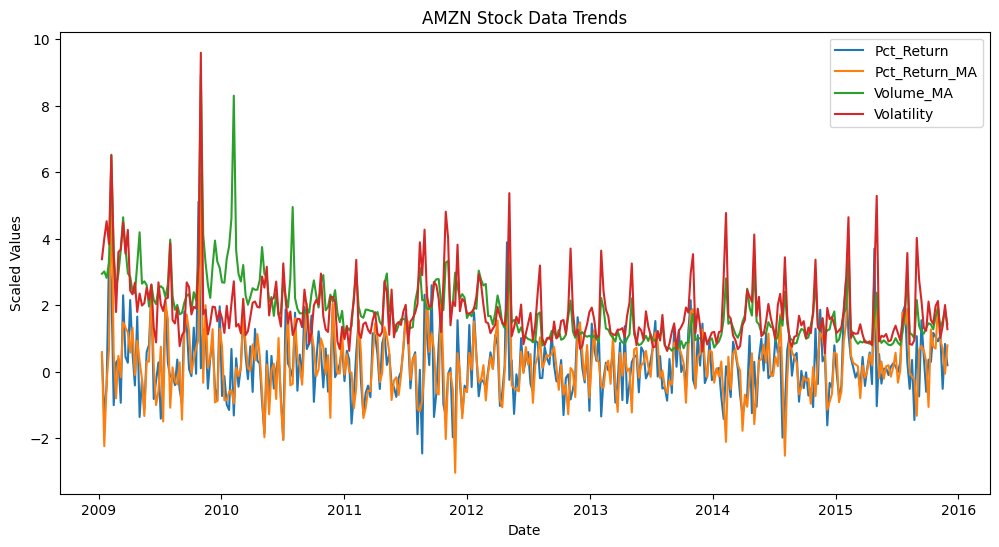

In [157]:
stock_data = get_stock_data(data, "AMZN", "W")
normalized_stock_data = normalize_stock_data(stock_data)
plot_stock_data(normalized_stock_data, "AMZN")

In [160]:
def label_data(stock_data: pd.DataFrame, train_date: str = "2020-12-31") -> tuple:
    stock_data_labeled = stock_data.copy()
    train_mask = stock_data_labeled.index <= train_date

    tau = stock_data_labeled.loc[train_mask, "Pct_Return"].abs().quantile(1/3)

    stock_data_labeled["Label"] = 0
    stock_data_labeled.loc[stock_data_labeled["Pct_Return"] > tau, "Label"] = 1
    stock_data_labeled.loc[stock_data_labeled["Pct_Return"] < -tau, "Label"] = -1

    label_counts = stock_data_labeled.loc[train_mask, "Label"].value_counts(normalize=True).to_dict()

    return stock_data_labeled, tau, label_counts


In [ ]:
def plot_labeled_histogram(stock_data_labeled: pd.DataFrame, stock: str, label_distribution: dict):
    mean_return = stock_data_labeled["Pct_Return"].mean()
    std_return = stock_data_labeled["Pct_Return"].std()

    lower_bound = mean_return - 3 * std_return
    upper_bound = mean_return + 3 * std_return

    plt.figure(figsize=(10, 5))

    bins = np.linspace(lower_bound, upper_bound, 100)

    plt.hist(
        stock_data_labeled[stock_data_labeled["Label"] == -1]["Pct_Return"].dropna(),
        bins=bins, color="red", edgecolor="black", alpha=0.7, label=f"Negative (-1): {label_distribution.get(-1, 0):.2%}"
    )

    plt.hist(
        stock_data_labeled[stock_data_labeled["Label"] == 0]["Pct_Return"].dropna(),
        bins=bins, color="gray", edgecolor="black", alpha=0.7, label=f"Neutral (0): {label_distribution.get(0, 0):.2%}"
    )

    plt.hist(
        stock_data_labeled[stock_data_labeled["Label"] == 1]["Pct_Return"].dropna(),
        bins=bins, color="green", edgecolor="black", alpha=0.7, label=f"Positive (+1): {label_distribution.get(1, 0):.2%}"
    )

    plt.xlabel("Scaled Pct Return")
    plt.ylabel("Frequency")
    plt.title(f"{stock} Scaled Percentage Return Distribution (Labeled)")
    plt.legend()
    plt.savefig(f"{stock.lower()}_pct_return_distribution.pdf")
    plt.show()


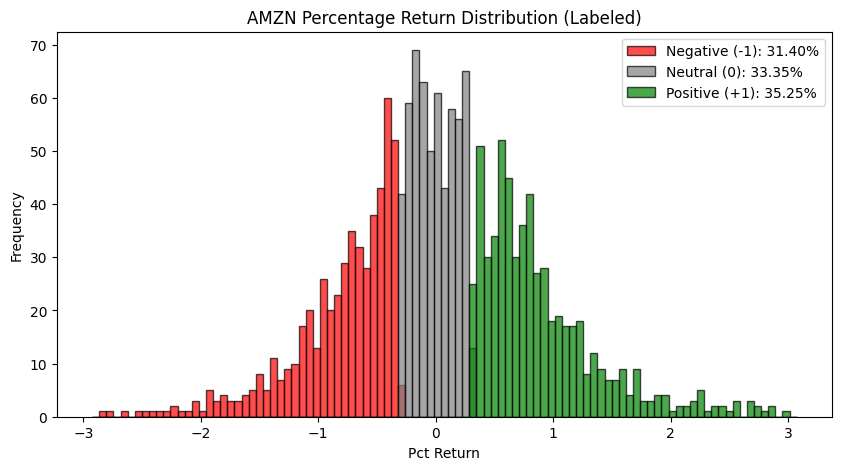

In [171]:
stock_data = get_stock_data(data, "AMZN", "D")
normalized_stock_data = normalize_stock_data(stock_data)
stock_data_labeled, tau, label_counts = label_data(normalized_stock_data)
plot_labeled_histogram(stock_data_labeled, "AMZN", label_counts)